<a href="https://colab.research.google.com/github/jjwjjwjjwjjwjjw/flower_mnist/blob/main/fasion_mnist_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [7]:
batch_size = 100
num_epochs = 20
learning_rate = 0.0001

In [3]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # v2 폴더 불러오기

Saving v2.zip to v2.zip


In [ ]:
!unzip v2.zip -d v2/    #폴더 만들어 압축 풀기

In [5]:
import torchvision

transform = transforms.Compose([
    transforms.Resize((28, 28)),  # 이미지 크기 조정
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])


train_data = torchvision.datasets.ImageFolder(root="/content/v2/Training Data", transform=transform)
test_data = torchvision.datasets.ImageFolder(root="/content/v2/Testing Data", transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [6]:
device = torch.device("cuda:0")  # CUDA 디바이스를 사용하려면 이렇게 정의합니다.
device_str = str(device) + ":0"


class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.layer1 = nn.Sequential(
            torch.nn.Linear(2352, 1024, bias=True),
            torch.nn.BatchNorm1d(1024),
            torch.nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            torch.nn.Linear(1024, 256, bias=True),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            torch.nn.Linear(256, 64, bias=True),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            torch.nn.Linear(64, 10, bias=True)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten
        x_out = self.layer1(x)
        x_out = self.layer2(x_out)
        x_out = self.layer3(x_out)
        x_out = self.layer4(x_out)
        return x_out

model = DNN().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [18]:
costs = []
total_batch = len(train_loader)
for epoch in range(num_epochs):
    total_cost = 0
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_cost += loss
    avg_cost = total_cost / total_batch
    print("Epoch:", "%03d" % (epoch+1), "Cost =", "{:.9f}".format(avg_cost))
    costs.append(avg_cost)

Epoch: 001 Cost = 0.454416662
Epoch: 002 Cost = 0.389695674
Epoch: 003 Cost = 0.292491883
Epoch: 004 Cost = 0.265926600
Epoch: 005 Cost = 0.237374142
Epoch: 006 Cost = 0.219870865
Epoch: 007 Cost = 0.218828186
Epoch: 008 Cost = 0.197877601
Epoch: 009 Cost = 0.159294665
Epoch: 010 Cost = 0.176084474
Epoch: 011 Cost = 0.177481487
Epoch: 012 Cost = 0.152033955
Epoch: 013 Cost = 0.159639508
Epoch: 014 Cost = 0.159729153
Epoch: 015 Cost = 0.140721083
Epoch: 016 Cost = 0.130112365
Epoch: 017 Cost = 0.134014696
Epoch: 018 Cost = 0.123008288
Epoch: 019 Cost = 0.124270849
Epoch: 020 Cost = 0.109868117


In [20]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (imgs, labels) in enumerate(test_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, argmax = torch.max(outputs, 1)
        total += imgs.size(0)
        correct += (labels == argmax).sum().item()

    print('Accuracy for {} images: {:.2f}%'.format(total/10, correct / total * 100))

Accuracy for 230.0 images: 50.13%


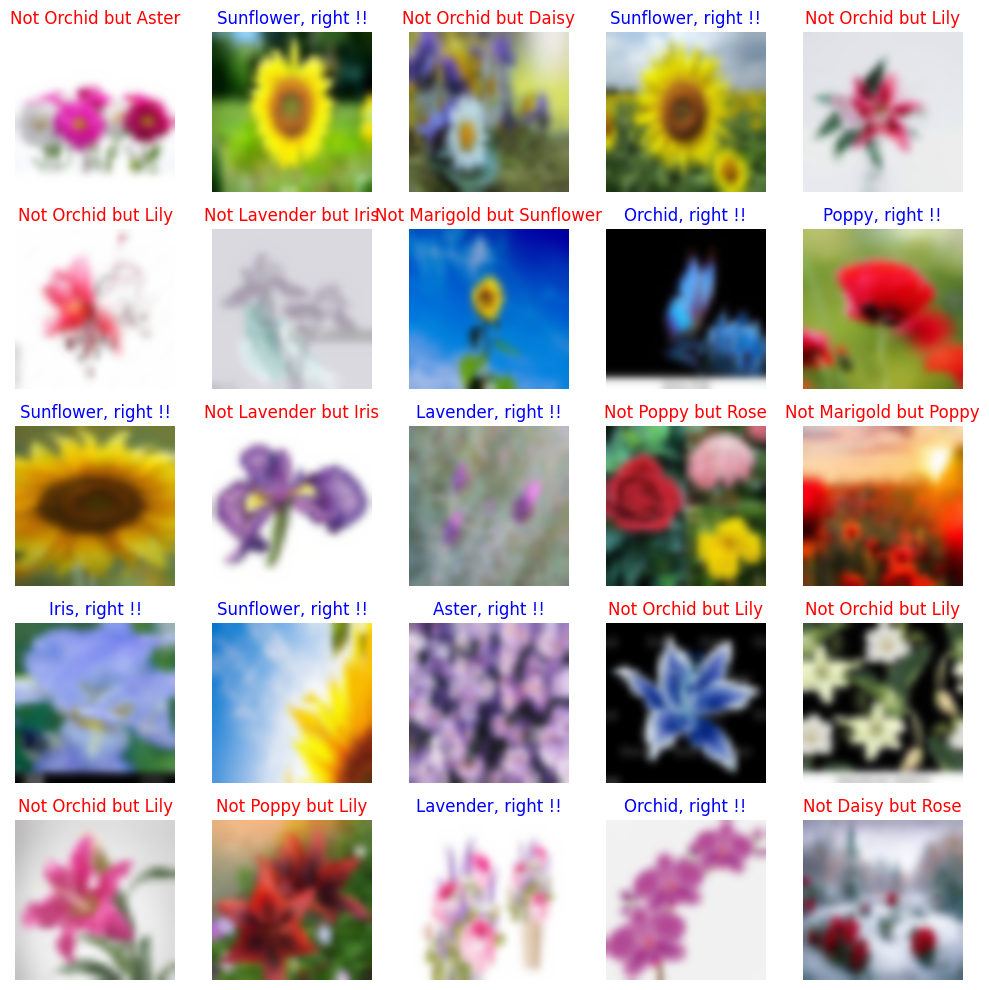

In [21]:
label_tags = {
    0: 'Aster',
    1: 'Daisy',
    2: 'Iris',
    3: 'Lavender',
    4: 'Lily',
    5: 'Marigold',
    6: 'Orchid',
    7: 'Poppy',
    8: 'Rose',
    9: 'Sunflower'
}
columns = 5
rows = 5
fig = plt.figure(figsize=(10, 10))

model.eval()
for i in range(1, columns * rows + 1):
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device)

    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = label_tags[argmax.item()]
    label = label_tags[test_data[data_idx][1]]

    ax = fig.add_subplot(rows, columns, i)
    if pred == label:
        ax.set_title(pred + ', right !!', color='blue')
    else:
        ax.set_title('Not ' + pred + ' but ' + label, color='red')
    plot_img = test_data[data_idx][0]  # 이미지 정규화를 역으로 수행하지 않음
    plot_img = plot_img / 2 + 0.5  # 이미지의 정규화를 역으로 조정
    plot_img = plot_img.permute(1, 2, 0)  # 이미지 차원 변환
    ax.imshow(plot_img, interpolation='bicubic')  # 이미지 보간법 설정
    ax.axis('off')

plt.tight_layout()
plt.show()
